# 05-ResNet and SENet

In this lab, we will implement one of the most popular CNN architectures, [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), with >180k citations and so called CNN's complementary enhancement model, [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507).

ResNet model won the 1st place in ILSVRC 2015 classification competition. The extremely deep representations also have excellent generalization performance on other recognition tasks, winning the 1st places on: ImageNet detection, ImageNet localization, COCO detection, and COCO segmentation in ILSVRC & COCO 2015 competitions.

## ResNet  
### The Problem of Deeper Neural Networks  
1. Vanishing/ Exploding Gradients
2. Overfitting
3. Model Degradation
4. Optimization/ Convergence Problem
5. Higher Computation Cost  

**Figure 1**: Training error (left) and test error (right) on CIFAR-10
with 20-layer and 56-layer “plain” networks. The deeper network
has higher training error, and thus test error.
<img src="img/degradation.png" width="400px">  
  
### How Degradation Problem Solved
Introducing a deep residual learning framework, by explicitly let the layers fit a residual mapping instead of these layers directly fit a desired underlying mapping:

$$\mathcal{F}(\text{x}):=\mathcal{H}(\text{x})-\text{x}$$

where:  
$\mathcal{F}(\text{x}) = \text{residual function}$  
$\mathcal{H}(\text{x}) = \text{desired underlying mapping}$  
$\text{x} = \text{identity mapping}$  

If $\mathcal{H}(\text{x})=\text{x}$, then $\mathcal{F}(\text{x}) = 0$, which means zero residual and identity mapping by a stack of nonlinear layers.

**Figure 2**: Residual Learning, a building block.
<img src="img/residual.png" width="200px">  

Shortcut Connections or Skip Connections:  


$$\text{y} = \mathcal{F}(\text{x}, \{\text{W}_{i}\})+\text{x}$$  
where:  
x, y = input, output  
$\mathcal{F}(\text{x}, \{\text{W}_{i}\})$ = residual mapping to be learned  

$$\mathcal{F} = \text{W}_{2}\sigma(\text{W}_{1}\text{x})$$ 
where:  
$\sigma$ = ReLU non-linearity  

Then, $\mathcal{F} + \text{x}$, performs element-wise addition  

The dimension of $\text{x}$ and $\mathcal{F}$ must be equal when performing addition operation. If this is not the case, we can perform a linear projection $\text{W}_{s}$ by the shortcut connections to match the dimensions:  
$$\text{y} = \mathcal{F}(\text{x}, \{\text{W}\}_{i}) + \text{W}_{s}\text{x}$$  


**Figure 3**: Training on **ImageNet**. Thin curves denote training error, and bold curves denote validation error of the center crops. Left: plain networks of 18 and 34-layers. Right: ResNets of 18 and 34 layers. In this plot, the residual networks have no extra parameter compared to their plain counterparts.  
<img src="img/resnet_graph.png" alt="Residual Training" width="500px">  

**Table 1**: Top-1 error(%, 10-crop testing) on ImageNet validation. Here the ResNets have no extra parameter compared to their plain counterparts.  

|           | plain    | ResNet   |
|-----------|----------|----------|
| 18 layers | 27.94    | 27.88    |
| 34 layers | 28.54    | **25.03**|

### ResNet Structure

ResNet structure has 4 stages. Each stage consists of a number of residual blocks. The number of residual blocks in each stage can be written as [$s_{1}, s_{2}, s_{3}, s_{4}$]. For example, in ResNet34, we have [3,4,6,3] number of blocks.

### ResNet18

ResNet18 is the simplest architecture among ResNet different models. It consists of 18 layers with 1.8 GFLOP operations per second and [2,2,2,2] residual blocks (two convolutional layers in each residual block) together with linear and softmax layers.

**Figure 4**: ResNet18 Architecture. At different stages, two residual connections are added in every two convolutional layers. The input size of first convolutional layer of each stage is spatially reduced to half and increased channel-wise to two times.  

<img src="img/resnet18.png" alt="ResNet18" width="700px">

### Residual Blocks
**Basic Residual Block**  

ResNet18 and ResNet34 use basic residual blocks which is the skip connection in every two convolutional layers.

**Bottleneck Block**  

In ResNet50 and deeper ResNet networks, a more complicated residual block, named Bottleneck Block, is use. The Bottleneck Block helps to mitigate the vanishing gradient issue in deeper layers. The components of the Bottleneck Block are described below:  

- Identity shortcut connection: The identity shortcut connection is a skip connection that directly passes the input to the output of the Bottleneck Block. This helps the gradient to flow a shorter path during back propagation.
- 1x1 convolution for dimension reduction: The first layer in Bottlenect Block is a 1x1 convolution with fewer filters than the subsequent 3x3 convolution. This reduces the dimensionality of the feature maps, making it computationally more efficient.
- 3x3 convolution for complex feature learning: The second layer is a 3x3 convolution layer, which applies more sophisticated feature extraction to the reduced set of feature maps.
- 1x1 convolution for feature map expansion: The final layer is another 1x1 convolutional layer that expands the number of feature maps again. This expansion allows the network to learn a richer set of features.  

**Figure 5**: A deeper residual function $\mathcal{F}$ for ImageNet. Left: a building block (on 56x56 feature maps) for ResNet-34. Right: a "Bottleneck" buildig block for ResNet-50/101/152.
<img src="img/blocks.png" alt="Basic and Bottleneck Blocks" width="500px">

**Figure 6**: Residual Blocks. #1. Ordinary basic blocks with identity mapping #2. Residual connection transformed by 1x1 convolution to change the input feature map size. The connection is no longer identity mapping.
<img src="img/residualblocks.png" alt="Residual Blocks" width="600px">  

Let's see how to implement a residual block in a resuable way. This code is modified from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py.

In [2]:
import os

os.environ['http_proxy'] = "http://squid.cs.ait.ac.th:3128/"
os.environ['https_proxy'] = "http://squid.cs.ait.ac.th:3128/"

In [3]:
!pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu116 --user

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     |████████████████████████████████| 1977.9 MB 659 bytes/s          ��████▎          | 1316.6 MB 89.4 MB/s eta 0:00:08
     |████████████████████████████████| 24.2 MB 28.6 MB/s            
     |████████████████████████████████| 4.2 MB 2.1 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Preliminaries (datasets and data loaders)

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import torch.nn.functional as F

# Set device to GPU or CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# Allow augmentation transform for training set, no augementation for val/test set

train_preprocess = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

eval_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download CIFAR-10 and split into training, validation, and test sets.
# The copy of the training dataset after the split allows us to keep
# the same training/validation split of the original training set but
# apply different transforms to the training set and validation set.

full_train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                                  download=True)

train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [40000, 10000])
train_dataset.dataset = copy(full_train_dataset)
train_dataset.dataset.transform = train_preprocess
val_dataset.dataset.transform = eval_preprocess

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=eval_preprocess)

# DataLoaders for the three datasets

BATCH_SIZE=128
NUM_WORKERS=4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


### Basic Block

In [2]:
class BasicBlock(nn.Module):
    '''
    BasicBlock: Simple residual block with two conv layers
    '''
    EXPANSION = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

### Bottleneck Block

In [3]:
class BottleneckBlock(nn.Module):
    '''
    BottleneckBlock: More powerful residual block with three convs, used for Resnet50 and up
    '''
    EXPANSION = 4
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.EXPANSION * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.EXPANSION * planes)

        self.shortcut = nn.Sequential()
        # If the output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != self.EXPANSION * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.EXPANSION * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


### ResNet

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

### ResNet Models

In [5]:
def ResNet18(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with two sets of two convolutions each: 2*2 + 2*2 + 2*2 + 2*2 = 16 conv layers
    last FC layer: 1
    Total layers: 1+16+1 = 18
    '''
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


def ResNet34(num_classes):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of two convolutions each: 3*2 + 4*2 + 6*2 + 3*2 = 32
    last FC layer: 1
    Total layers: 1+32+1 = 34
    '''
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


def ResNet50(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of three convolutions each: 3*3 + 4*3 + 6*3 + 3*3 = 48
    last FC layer: 1
    Total layers: 1+48+1 = 50
    '''
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)


def ResNet101(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 23, 3] sets of three convolutions each: 3*3 + 4*3 + 23*3 + 3*3 = 99
    last FC layer: 1
    Total layers: 1+99+1 = 101
    '''
    return ResNet(BottleneckBlock, [3, 4, 23, 3], num_classes)


def ResNet152(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 8, 36, 3] sets of three convolutions each: 3*3 + 8*3 + 36*3 + 3*3 = 150
    last FC layer: 1
    Total layers: 1+150+1 = 152
    '''
    return ResNet(BottleneckBlock, [3, 8, 36, 3], num_classes)

### Train Function

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model: train a model on a dataset
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # for process anything, device and dataset must put in the same place.
                # If the model is in GPU, input and output must set to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # it uses for update training weights
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        # print('outputs', outputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

### Training

In [13]:
resnet = ResNet18().to(device)
# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
params_to_update = resnet.parameters()
# Now we'll use Adam optimization
optimizer = optim.Adam(params_to_update, lr=0.01)

best_model, val_acc_history, loss_acc_history = train_model(resnet, dataloaders, criterion, optimizer, 25, 'resnet18_bestsofar')

Epoch 0/24
----------
train Loss: 1.7970 Acc: 0.3443
Epoch time taken:  88.19721913337708
val Loss: 1.5302 Acc: 0.4386
Epoch time taken:  112.1596896648407

Epoch 1/24
----------
train Loss: 1.3015 Acc: 0.5245
Epoch time taken:  83.82021164894104
val Loss: 1.3259 Acc: 0.5381
Epoch time taken:  107.10150599479675

Epoch 2/24
----------
train Loss: 1.0038 Acc: 0.6428
Epoch time taken:  84.80452013015747
val Loss: 0.9669 Acc: 0.6633
Epoch time taken:  111.69659066200256

Epoch 3/24
----------
train Loss: 0.7965 Acc: 0.7189
Epoch time taken:  88.39640998840332
val Loss: 0.7722 Acc: 0.7284
Epoch time taken:  112.60797166824341

Epoch 4/24
----------
train Loss: 0.6492 Acc: 0.7743
Epoch time taken:  84.97840690612793
val Loss: 0.7564 Acc: 0.7363
Epoch time taken:  108.54917168617249

Epoch 5/24
----------
train Loss: 0.5345 Acc: 0.8133
Epoch time taken:  84.50002646446228
val Loss: 0.6027 Acc: 0.7873
Epoch time taken:  107.57982969284058

Epoch 6/24
----------
train Loss: 0.4494 Acc: 0.8436


## Squeeze and Excitation Networks
[Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)

Squeeze and Excite networks (SENet) is a building block for CNNs that improves channel interdependencies at almost no computational cost. The modification from the ordinary ResNet is easy. The main idea of SENet is add parameters in each channel, then the network can adaptively adjust the weighting of each feature map.

SENets are all about changing this by adding a content aware mechanism to weight each channel adaptively. In it’s most basic form this could mean adding a single parameter to each channel and giving it a linear scalar how relevant each one is.

The concept of squeeze and excite (SENet) is shown here:  

**Figure 7**: SE Schema, Right: SE-Inception Module, Left: SE-ResNet Module  
<img src="img/senet.png" alt="SENet" width="600px">  

**Figure 8**: SE-ResNet  
<img src="img/seresnet.png" alt="SEResNet" width="600px">  

**Figure 9**: SE-Inception
<img src="img/seinception.png" alt="SEInception" width="600px">  

SE modules can be added anywhere as shown below:  
**Figure 10**: Different Types of SENet Blocks
<img src="img/senetblocks.png" alt="SENet Blocks" width="700px">  

Implementation is beautifully simple. Here's an example of an SE module from https://github.com/moskomule/senet.pytorch/blob/23839e07525f9f5d39982140fccc8b925fe4dee9/senet/se_module.py#L4.

Let's use the standard option (option b above) recommended by the authors:

In [7]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
class ResidualSEBasicBlock(nn.Module):
    '''
    ResidualSEBasicBlock: Standard two-convolution residual block with an SE Module between the
                          second convolution and the identity addition
    '''
    EXPANSION = 1

    def __init__(self, in_planes, out_planes, stride=1, reduction=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.se = SELayer(out_planes, reduction)

        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with a 1x1 conv
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)              # se net add here
        out += self.shortcut(x)         # shortcut just plus it!!!
        out = F.relu(out)
        return out


def ResSENet18(num_classes = 10):
    return ResNet(ResidualSEBasicBlock, [2, 2, 2, 2], num_classes)

Let's try the SE version of ResNet18 and compare in terms of time and accuracy.

In [10]:
ressenet = ResSENet18().to(device)
# Optimizer, loss function
criterion2 = nn.CrossEntropyLoss()
params_to_update2 = ressenet.parameters()
optimizer2 = optim.Adam(params_to_update2, lr=0.01)

best_model2, val_acc_history2, loss_acc_history2 = train_model(ressenet, dataloaders, criterion2, optimizer2, 10, 'ressenet18_bestsofar')

Epoch 0/9
----------
train Loss: 1.6667 Acc: 0.3967
Epoch time taken:  100.43781399726868
val Loss: 1.3503 Acc: 0.5080
Epoch time taken:  140.59627676010132

Epoch 1/9
----------
train Loss: 1.1453 Acc: 0.5889
Epoch time taken:  94.8960223197937
val Loss: 1.0762 Acc: 0.6179
Epoch time taken:  120.52948188781738

Epoch 2/9
----------
train Loss: 0.8689 Acc: 0.6919
Epoch time taken:  89.81472086906433
val Loss: 0.8887 Acc: 0.6913
Epoch time taken:  115.38424301147461

Epoch 3/9
----------
train Loss: 0.7115 Acc: 0.7500
Epoch time taken:  90.2288670539856
val Loss: 0.8323 Acc: 0.7085
Epoch time taken:  122.13032507896423

Epoch 4/9
----------
train Loss: 0.5883 Acc: 0.7926
Epoch time taken:  91.60757064819336
val Loss: 0.6456 Acc: 0.7777
Epoch time taken:  119.77963471412659

Epoch 5/9
----------
train Loss: 0.4883 Acc: 0.8299
Epoch time taken:  90.79474306106567
val Loss: 0.5983 Acc: 0.7899
Epoch time taken:  120.17099905014038

Epoch 6/9
----------
train Loss: 0.4158 Acc: 0.8541
Epoch t

In [9]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history, val_acc_history2, loss_acc_history2):
    plt.plot(loss_acc_history, label = 'ResNet18')
    plt.plot(loss_acc_history2, label = 'ResSENet18')
    plt.title('Training loss over time')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'ResNet18')
    plt.plot(val_acc_history2, label = 'ResSENet18')
    plt.title('Validation accuracy over time')
    plt.legend()
    plt.show()

In [22]:
# val_acc_history = [val.cpu().numpy() for val in val_acc_history]
# val_acc_history2 = [val.cpu().numpy() for val in val_acc_history2]

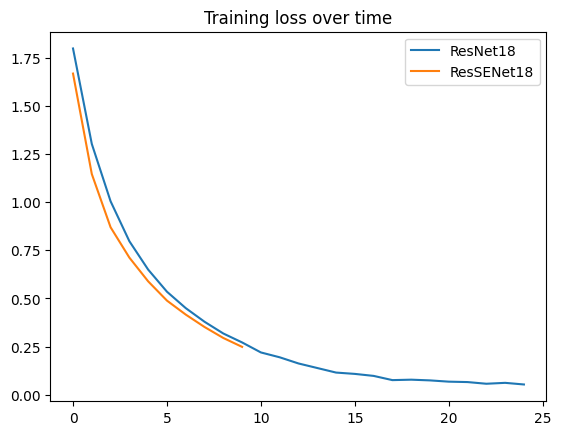

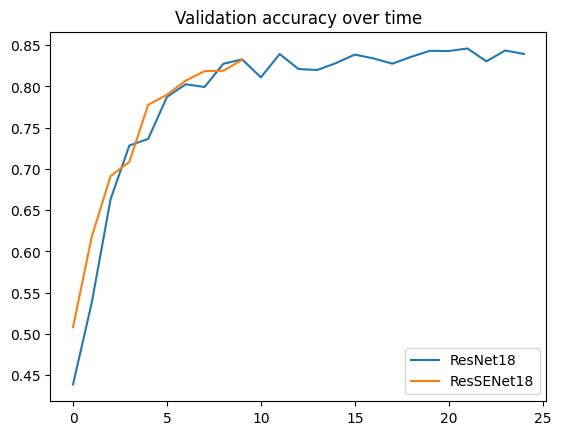

In [23]:
plot_data(val_acc_history, loss_acc_history, val_acc_history2, loss_acc_history2)

Interestingly, we can see that the additional parameters accelerate learning of the training set without causing any degredation on the validation set and in fact improving validation set performance early on.

### Create your own dataset

If you want to use the model that you created, downloaded with your own project, you must know that each dataset does not store in the same format. You need to consider the data to get images and label as you want. For computer vision dataset, there are some example types as:

1. Classification: images, labels
    - folderClassA, folderClassB
    - image_name
    - images folder, csv_labels
2. Detection: images, annotations
    - Yolo: images folder, annotation files
3. Segmentation: images, annotations
    - images folder, masks folder
    - images folder, annotation files
4. Image synthesis: images, labels (optional)
5. Image transfer: imagesA, imagesB

In this lab, I will explain only image classification.

### Experiment: Kaprao-Horapa

First, let's load the [vege_dataset.zip](https://www.dropbox.com/s/eip79rx1mmofbov/vege_dataset.zip?dl=0).
The dataset contains 2 classes of kaprao and horapa. Both are basils but different families and usages.

Extract file and see the folder inside

The dataset contains 2 folders with 2 different names, so we can use the folder as dataset.

### Create Dataset class using pytorch

Let's create the empty dataset class. The input of the class are
- the dataset library of <code>../vege_dataset/</code>, when <code>..</code> is the root path of your dataset.
- transform function

In [10]:
# import important library
from torch.utils.data import Dataset, DataLoader


class BasilDataset(Dataset):
    def __init__(self, root_path="/vege_dataset/", transform=None):
        return
    
    def __len__(self):
        return 0
    
    def __getitem__(self, i):
        return

The important function of the dataset class are
- <code>__init__</code>: The constructor <code>__init__</code> initializes the required parameters that are owned by the class BasilDataset.
- <code>__len__</code>: The function returns total number of dataset
- <code>__getitem__</code>: This function receives an index `i` as an argument which is generated from the **DataLoader** class. `i` is random if `shuffle` parameter from the **DataLoader** is set to `True`. The <code>__getitem__</code> function selects the index `i` from the dataset and perform the transforms and returns.

### Get one item of your dataset in the list

In [25]:
from torch.utils.data import Dataset, DataLoader
from os import listdir
from PIL import Image


class BasilDataset(Dataset):
    def __init__(self, root_path="vege_dataset/", transform=None):
        # keep root directory
        self.dir = root_path
        # keep transform
        self.transform = transform

        # read all files in kapao and horapa folder
        list_kaprao = listdir(root_path + 'kapao/')
        list_horapa = listdir(root_path + 'horapa/')
        # calculate all number for each class (just in case)
        self.kaprao_len = len(list_kaprao)
        self.horapa_len = len(list_horapa)

        # put the data file path into ids
        self.ids = [self.dir + 'kapao/' + file for file in list_kaprao if not file.startswith('.')]
        self.ids.extend([self.dir + 'horapa/' + file for file in list_horapa if not file.startswith('.')])
        
    def __len__(self):
        return self.kaprao_len + self.horapa_len
    
    def __getitem__(self, i):
        idx = self.ids[i]
        img_file = idx
        
        # open photo
        pil_img = Image.open(img_file)
        
        # resize, normalize and convert to pytorch tensor
        if self.transform:
            img = self.transform(pil_img)
        self.pil_img = pil_img
            
        # get label from file list counter
        if i < self.kaprao_len:
            label = 0
        else:
            label = 1
            
        return {
            'image': img,
            'label': label,
            'file_name' : img_file,
        }

### Test dataset

Now you can test your dataset to get images.

In [26]:
root = "vege_dataset/"

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(28), # CenterCrop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = BasilDataset(root, transform)

kaprao
vege_dataset/kapao/20220425_204945_resize.jpg


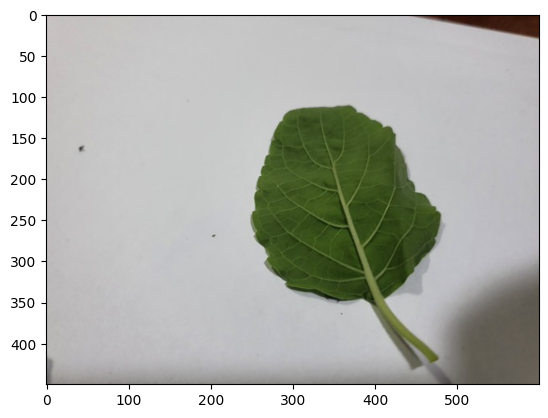

In [27]:
import matplotlib.pyplot as plt

output_label = ['kaprao', 'horapa']

batch = dataset[0]
image, label, filename = batch['image'], batch['label'], batch['file_name']
pil_img = Image.open(filename)

print(output_label[label])
print(filename)
# (3, 224, 224) pytorch
# pyplot -> (224,224,3)
plt.imshow(pil_img)
plt.show()

### Create a Train Loader

In [28]:
train_loader = DataLoader(dataset, batch_size=64, shuffle=True, pin_memory=True)

### Initialize an instance using the resnet class we created above

In [29]:
resnet = ResNet18(2).to(device)
# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
params_to_update = resnet.parameters()
# Now we'll use Adam optimization
optimizer = optim.Adam(params_to_update, lr=0.01)

In [31]:
n_epochs = 10

loss_history = []
loss_history_epoch = []
accuracy = []

for epoch in range(1, n_epochs + 1):
    epoch_iter = 0                  # the number of training iterations in current epoch, reset to 0 every epoch
    running_loss = 0
    running_corrects = 0
    for batch in train_loader:
        image, label, filename = batch['image'], batch['label'], batch['file_name']
            
        epoch_iter += image.shape[0]

        image = image.to(device)
        label = label.to(device)

        # training only
        optimizer.zero_grad()

        output = resnet(image)

        # 0, 1, 0, 0 ---> 0.2, 0.6, 0.1, 0.1
        loss = criterion(output, label)       # training

        # prediction - real use
        _, preds = torch.max(output, 1)

        running_loss += loss.item() * image.size(0)
        running_corrects += torch.sum(preds == label.data)

        loss.backward()       # back propagation -> calculate that how much value to update weight
        optimizer.step()      #update weight

        loss_history.append(loss.item() * image.size(0))
        if (epoch_iter % 640 == 0):
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(epoch_iter, loss.item(), running_corrects / epoch_iter))
        
    loss_history_epoch.append(running_loss / epoch_iter)
    accuracy.append(running_corrects / epoch_iter)

    print('Epoch: {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, running_loss / epoch_iter, running_corrects / epoch_iter * 100.0))

640 Loss: 0.4956 Acc: 0.7719
1280 Loss: 0.3911 Acc: 0.8000
Epoch: 1 Loss: 0.4374 Acc: 80.1291
640 Loss: 0.3803 Acc: 0.8469
1280 Loss: 0.2453 Acc: 0.8586
Epoch: 2 Loss: 0.3423 Acc: 85.7245
640 Loss: 0.2066 Acc: 0.8688
1280 Loss: 0.2079 Acc: 0.8844
Epoch: 3 Loss: 0.2800 Acc: 88.3070
640 Loss: 0.2755 Acc: 0.9156
1280 Loss: 0.4273 Acc: 0.8828
Epoch: 4 Loss: 0.3084 Acc: 87.7331
640 Loss: 0.2270 Acc: 0.8906
1280 Loss: 0.3684 Acc: 0.8953
Epoch: 5 Loss: 0.2586 Acc: 89.5265
640 Loss: 0.3030 Acc: 0.9047
1280 Loss: 0.2160 Acc: 0.9047
Epoch: 6 Loss: 0.2391 Acc: 90.1004
640 Loss: 0.1401 Acc: 0.9234
1280 Loss: 0.2893 Acc: 0.9164
Epoch: 7 Loss: 0.2290 Acc: 91.4634
640 Loss: 0.2136 Acc: 0.9000
1280 Loss: 0.1306 Acc: 0.9086
Epoch: 8 Loss: 0.2308 Acc: 90.8178
640 Loss: 0.2111 Acc: 0.9000
1280 Loss: 0.2331 Acc: 0.9008
Epoch: 9 Loss: 0.2399 Acc: 90.3874
640 Loss: 0.0833 Acc: 0.9078
1280 Loss: 0.1068 Acc: 0.9211
Epoch: 10 Loss: 0.1804 Acc: 92.3242


## Take home exercises
1. Run the lab instruction. For the dataset part, split randomly to the data into 90% of train set and 10% of test set. (30 points)
2. Create InceptionResNet. Notice that 1 inception block is similar to one ResNet Module. You can use the pattern of InceptionNet from previous Lab. Train the model using CIFAR10 dataset, plot graphs on the outputs. (40 points)
3. Find your own dataset which contains at least 3 classes. If you download from somewhere, please reference in your report. Make your own dataset class, explain how to setup your data and the label. Train the dataset in ResNet and InceptionResNet, show your results. (30 points)

### Turn-in report

Export the output of the lab in PDF. You can do in the same file or create separate files of your homework and in-class exercise. Submit in PDF file and Jupyter notebook.

You don't need to upload dataset.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms


In [12]:
train_preprocess = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

full_dataset = datasets.CIFAR10('../data', train=True, download=True)

train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [45000, 5000])
train_dataset.dataset = copy(full_dataset)
train_dataset.dataset.transform = train_preprocess

valid_dataset.dataset.transform = test_preprocess

test_dataset = datasets.CIFAR10('../data', train=False, download=True, transform=test_preprocess)

BATCH_SIZE=128
NUM_WORKERS=4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

dataloaders = {"train": train_dataloader, "val": valid_dataloader}

Files already downloaded and verified
Files already downloaded and verified


In [13]:
class SEInception(nn.Module):
    def __init__(self, channel, reduction_size=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.layers = nn.Sequential(
            nn.Linear(channel, channel // reduction_size, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction_size, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.layers(y).view(b, c, 1, 1)

        return x * y.expand_as(x)

In [14]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super().__init__()
        self.in_planes = in_planes
        self.n1x1 = n1x1
        self.n3x3red = n3x3red
        self.n3x3 = n3x3
        self.n5x5red = n5x5red
        self.n5x5 = n5x5
        self.pool_planes = pool_planes

        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)



In [15]:
class InceptionSEBlock(nn.Module):
    def __init__(self, reduction=16):
        super().__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True)
        )
        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.se_a3 = SEInception(256, reduction)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)
        self.se_b3 = SEInception(480, reduction)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.se_a4 = SEInception(512, reduction)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.se_b4 = SEInception(512, reduction)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.se_c4 = SEInception(512, reduction)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.se_d4 = SEInception(528, reduction)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.se_e4 = SEInception(832, reduction)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.se_a5 = SEInception(832, reduction)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)
        self.se_b5 = SEInception(1024, reduction)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)
        
    
    def forward(self, x):
        out = self.pre_layers(x)
        
        out = self.a3(out)
        out = self.se_a3(out)
        out = self.b3(out)
        out = self.se_b3(out)

        out = self.maxpool(out)

        out = self.a4(out)
        out = self.se_a4(out)
        out = self.b4(out)
        out = self.se_b4(out)
        out = self.c4(out)
        out = self.se_c4(out)
        out = self.d4(out)
        out = self.se_d4(out)
        out = self.e4(out)
        out = self.se_e4(out)

        out = self.maxpool(out)

        out = self.a5(out)
        out = self.se_a5(out)
        out = self.b5(out)
        out = self.se_b5(out)

        out = self.avgpool(out)
        
        out = out.view(out.size(0), -1)

        out = self.linear(out)

        return out


In [10]:
inception = InceptionSEBlock().to(device)
criterion3 = nn.CrossEntropyLoss()
params_to_update3 = inception.parameters()
optimizer3 = torch.optim.Adam(params_to_update3, lr=0.01)

best_model3, val_acc_history3, loss_acc_history3 = train_model(inception, dataloaders, criterion3, optimizer3, 10, 'inceptionse_best')

Epoch 0/9
----------
train Loss: 1.6500 Acc: 0.3814
Epoch time taken:  78.05996870994568
val Loss: 1.5650 Acc: 0.4338
Epoch time taken:  80.72555875778198

Epoch 1/9
----------
train Loss: 1.0980 Acc: 0.6050
Epoch time taken:  77.40044045448303
val Loss: 1.1937 Acc: 0.5850
Epoch time taken:  80.03882074356079

Epoch 2/9
----------
train Loss: 0.8407 Acc: 0.7010
Epoch time taken:  78.16854429244995
val Loss: 1.0163 Acc: 0.6518
Epoch time taken:  80.92101168632507

Epoch 3/9
----------
train Loss: 0.7067 Acc: 0.7493
Epoch time taken:  79.06149101257324
val Loss: 0.8814 Acc: 0.7046
Epoch time taken:  81.69841384887695

Epoch 4/9
----------
train Loss: 0.5966 Acc: 0.7904
Epoch time taken:  78.4614667892456
val Loss: 0.6827 Acc: 0.7716
Epoch time taken:  81.10158801078796

Epoch 5/9
----------
train Loss: 0.5189 Acc: 0.8193
Epoch time taken:  79.31606006622314
val Loss: 0.7128 Acc: 0.7526
Epoch time taken:  82.00607180595398

Epoch 6/9
----------
train Loss: 0.4563 Acc: 0.8421
Epoch time ta

In [18]:
# Cifar-10 with 3 classes as per 3rd task of assignment
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar10_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

class_to_idx = {'airplane': 0, 'car': 1, 'bird': 2}
indices = [i for i, label in enumerate(cifar10_data.targets) if label in [0, 1, 2]]
filtered_data = torch.utils.data.Subset(cifar10_data, indices)

train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(cifar10_data, train_indices)
val_dataset = torch.utils.data.Subset(cifar10_data, val_indices)

Files already downloaded and verified


In [19]:
class CustomCIFAR10(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

In [20]:
train_loader = DataLoader(CustomCIFAR10(train_dataset), batch_size=32, shuffle=True)
val_loader = DataLoader(CustomCIFAR10(val_dataset), batch_size=32, shuffle=False)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in [0, 1, 2]]
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)
test_loader = DataLoader(CustomCIFAR10(test_dataset), batch_size=32, shuffle=False)

Files already downloaded and verified


In [21]:
dataloaders = {"train": train_loader, "val": val_loader}

In [22]:
inception = InceptionSEBlock().to(device)
criterion3 = nn.CrossEntropyLoss()
params_to_update3 = inception.parameters()
optimizer3 = torch.optim.Adam(params_to_update3, lr=0.01)

best_model3, val_acc_history3, loss_acc_history3 = train_model(inception, dataloaders, criterion3, optimizer3, 10, 'inceptionse_custombest')

Epoch 0/9
----------
train Loss: 0.6875 Acc: 0.7063
Epoch time taken:  35.515445947647095
val Loss: 0.5284 Acc: 0.7947
Epoch time taken:  37.92167091369629

Epoch 1/9
----------
train Loss: 0.4828 Acc: 0.8097
Epoch time taken:  33.28249907493591
val Loss: 0.4715 Acc: 0.8187
Epoch time taken:  35.696314573287964

Epoch 2/9
----------
train Loss: 0.4088 Acc: 0.8428
Epoch time taken:  36.274190187454224
val Loss: 0.3390 Acc: 0.8623
Epoch time taken:  38.73150420188904

Epoch 3/9
----------
train Loss: 0.3513 Acc: 0.8627
Epoch time taken:  33.2001314163208
val Loss: 0.5081 Acc: 0.7970
Epoch time taken:  35.61965608596802

Epoch 4/9
----------
train Loss: 0.3243 Acc: 0.8745
Epoch time taken:  33.14908480644226
val Loss: 0.3207 Acc: 0.8743
Epoch time taken:  35.592175245285034

Epoch 5/9
----------
train Loss: 0.2923 Acc: 0.8875
Epoch time taken:  33.2407591342926
val Loss: 0.3371 Acc: 0.8633
Epoch time taken:  35.72817087173462

Epoch 6/9
----------
train Loss: 0.2527 Acc: 0.9048
Epoch time

In [23]:
ressenet = ResSENet18().to(device)
# Optimizer, loss function
criterion2 = nn.CrossEntropyLoss()
params_to_update2 = ressenet.parameters()
optimizer2 = optim.Adam(params_to_update2, lr=0.01)

best_model2, val_acc_history2, loss_acc_history2 = train_model(ressenet, dataloaders, criterion2, optimizer2, 10, 'ressenet18_bestsofar')

Epoch 0/9
----------
train Loss: 0.7277 Acc: 0.7036
Epoch time taken:  15.984295129776001
val Loss: 0.5493 Acc: 0.7757
Epoch time taken:  17.428098917007446

Epoch 1/9
----------
train Loss: 0.4958 Acc: 0.8018
Epoch time taken:  15.969259977340698
val Loss: 0.5784 Acc: 0.7790
Epoch time taken:  17.403835773468018

Epoch 2/9
----------
train Loss: 0.4151 Acc: 0.8359
Epoch time taken:  16.0020170211792
val Loss: 0.4371 Acc: 0.8183
Epoch time taken:  17.438579082489014

Epoch 3/9
----------
train Loss: 0.3605 Acc: 0.8584
Epoch time taken:  16.00574564933777
val Loss: 0.3319 Acc: 0.8667
Epoch time taken:  17.444746255874634

Epoch 4/9
----------
train Loss: 0.3231 Acc: 0.8740
Epoch time taken:  16.01414942741394
val Loss: 0.3017 Acc: 0.8827
Epoch time taken:  17.482289791107178

Epoch 5/9
----------
train Loss: 0.2766 Acc: 0.8914
Epoch time taken:  16.00528836250305
val Loss: 0.3072 Acc: 0.8787
Epoch time taken:  17.45339560508728

Epoch 6/9
----------
train Loss: 0.2523 Acc: 0.9024
Epoch 

In [26]:
val_acc_history3 = [val.cpu().numpy() for val in val_acc_history3]
val_acc_history2 = [val.cpu().numpy() for val in val_acc_history2]

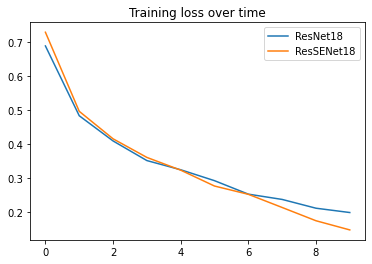

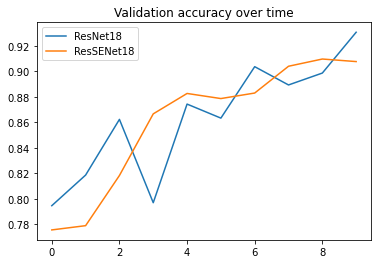

In [27]:
plot_data(val_acc_history3, loss_acc_history3, val_acc_history2, loss_acc_history2)